# Homework 5 - K-Means, SVM with the Kernel Trick, and Neural Networks
## CSCI 4622 - Spring 2022
***
**Name**: $Will Yelton$
***

This assignment is due on Canvas by **11.59 PM on Wednesday, April 27th**.

Submit only this Jupyter notebook to Canvas with the name format `PS5_<yourname>.ipynb`.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.

Remember that you are encouraged to discuss the problems with your classmates and instructors,
but **you must write all code and solutions on your own**, and list any people or sources consulted.

In [1]:
#!pip install -r requirements.txt #uncomment to install all required packages
import numpy as np
import matplotlib.pyplot as plt
import tests
import data

# Assignment Setup

For this problem set, we'll be using three synthetic datasets plotted below. From left to right: co-centric circles `circles`, blobs with 5 centers `multi_blobs`, and blobs with 2 centers `binary_blobs`.

Each of the dataset instances has (`data`, `labels`) attributes that are split into `train` and `test` partitions.
In the first problem, we'll be implementing K-means and evaluate it on the on the three datasests. 

In the second problem, we'll be training Support Vector Machines (SVM) with the kernel trick and test it on `circles` and `binary_blobs`.

And in the last problem, we'll implement our Multi-Layer Perceptron from scratch and test it on the `circles` dataset.

The three problems are entirely independent and could be solved in any order you deem fitting.

For this semester, we've also added a bonus problem on reinforcement learning to get you familiar with its concepts and some of its practical limitations.



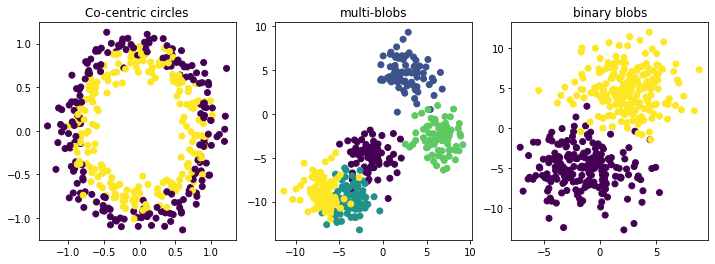

In [2]:
%matplotlib inline
# Do not modify this cell
circles = data.Circles()
multi_blobs = data.DataBlobs(centers=5, std=1.5)
binary_blobs = data.DataBlobs(centers=2, std=2.5)

fig, axs = plt.subplots(1, 3)
fig.set_figheight(4), fig.set_figwidth(12)
for i, (dataset, name) in enumerate([(circles, "Co-centric circles"),
                                     (multi_blobs, "multi-blobs"),
                                     (binary_blobs, "binary blobs")]):
    axs[i].set_title(name)
    axs[i].scatter(dataset.X[:, 0], dataset.X[:, 1], c=dataset.labels)
plt.show()

# Problem 1 : K-means (40 points)


The goal of K-means is to partition the data into $k$ clusters such that the sum of intra-cluster variances is minimal.
We will be using Euclidean distance as our variance measure, so for cluster $C_i = \{x_1,x_2,... x_{m_i}\}$, its intra-cluster variance $V(C_i)$ is defined as:

$$
V(C_i) = \sum_{j=1}^{m_i} ||x_j - \mu_i||^2
$$

where $\mu_i = \frac{1}{m} \sum_{i=1}^{m_i} x_i$. $\mu_i$ is called the centroid of cluster $C_i$.

So for $k$ clusters, K-means objective is:
$$
\min_{C_1,C_2\ldots C_k}\sum_{i=1}^{k}V(C_i) = \min_{C_1,C_2\ldots C_k} \sum_{i=1}^{k} \sum_{j=1}^{m_i} ||x_j - \mu_i||^2
$$

Each sample $x_i$ is assigned to the cluster of the closest centroid. Hence, finding the optimal partition $\{C_1,C_2...C_k\}$ that minimizes the objective is equivalent to finding the optimal centroids.

Unfortunately, there is no algorithm that reaches the global optima for K-means, but we'll be implementing the most famous heuristic for the problem: Llyod algorithm. It works as follows:

- Initialize the centroids with **unique** random samples (`initialize_centroids`), initial objective = $+\infty$
- Repeat until convergence:
    - Compute the distances matrix $D$ between samples and centroids (`compute_distances`)
    - Use $D$ to assign each sample to the cluster with the closest centroid (`computes_assignments`)
    - Update the centroids as centers of the new cluster assignments (`compute_centroids`)
    - Compute the new objective (`compute_objective`)
    - Stop if the improvement ratio of the objective is less than $\epsilon$

The improvement ratio equal to `|new_objective - previous_objective|/|previous_objective|`.


- **1.1 [2 points]** `initialize_centroids` : select K **distinct** samples from the matrix data `X` and use them as the initial centroids. Store these centroids in the class attribute `self.centroids` as an `np.array` of shape $k \times d$.
- **1.2 [5 points]** `compute_distances` : compute the distance of each sample $x_i$ to every centroid $c_j$ and return the result as a matrix `distances_matrix` of size $N \times k$ where `N` is the number of samples and `k` is the chosen number of clusters to be found. The cell `(i,k)` shall contain the euclidean distance between sample $x_i$ and centroid $m_k$.
- **1.3 [3 points]** `compute_assignments` : given the distances matrix of size $N \times k$ return an array of labels in which each element is an integer in the range $[0, k-1]$ and it represents which centroid it's closest to.
- **1.4 [5 points]** `compute_centroids` : Compute the new centroids depending on the new set of samples that has been alloted to each cluster.
- **1.5 [6 points]** `fit` : This shall contain your main loop which implements the algorithm described above. You'll sequentially call the methods above to find the $k$ centroids. Break the loop when the improvement ratio of the objective is within `rtol`. At the end (or start, depending on how you code it) of each iteration, call the method `save_snapshot` to save the current clustering status and save the current objective value in the `history` list.
- **1.6 [4 points]** `predict` : Given new samples, return their assigned clusters that were learned in the `fit` step.

While we're working on 2-d data (d=2) for visualization purposes, your implementation should handle any number of features.

In [3]:
class KMeans:
    def __init__(self, k, rtol=1e-3):
        """
        :param k: (int) number of means/centroids to evaluate
        :param rtol: (float) relative tolerance, `epsilon` from the markdown
        """
        self.k = k
        self.centroids = None
        self.snapshots = []  # buffer for progress plots
        self.rtol = rtol

    def initialize_centroids(self, X):
        """
        Randomly select k **distinct** samples from the dataset in X as centroids
        @param X: np.ndarray of dimension (num_samples, num_features)
        @return: centroids array of shape (k, num_features)
        """
        centroids = None
        # Workspace 1.1
        #BEGIN 
        centroids = []
        visited = []
        for i in range(self.k):
            curr_idx = np.random.randint(X.shape[0]) ##IS this distinct?????s
            if curr_idx not in visited:
                visited.append(curr_idx)
                centroids.append(X[curr_idx])
        centroids = np.array(centroids)
        self.centroids = centroids
        #END
        return centroids

    def compute_distances(self, X):
        """
        Compute a distance matrix of size (num_samples, k) where each cell (i, j) represents the distance between
        i-th sample and j-th centroid. We shall use Euclidean distance here.
        :param X: np.ndarray of shape (num_samples, num_features)
        :return: distances_matrix : (np.ndarray) of the dimension (num_samples, k)
        """
        distances_matrix = np.zeros((X.shape[0], self.k))
        # Workspace 1.2
        #BEGIN 
        for i in range(X.shape[0]):
            for k in range(len(self.centroids)): ##norm is euclidian distance 
                distances_matrix[i, k] = np.linalg.norm(X[i] - self.centroids[k])
        #END
        return distances_matrix

    @staticmethod
    def compute_assignments(distances_to_centroids):
        """
        Compute the assignment array of shape (num_samples,) where assignment[i] = j if and only if
        sample i belongs to the cluster of centroid j
        :param distances_to_centroids: The computed pairwise distances matrix of shape (num_samples, k)
        :return: assignments array of shape (num_samples,)
        """

        assignments = np.zeros((distances_to_centroids.shape[0],))

        # Workspace 1.3
        #BEGIN 
        idx = 0
        for row in distances_to_centroids:
            min_num = np.inf
            best_index = -1
            for k in range(len(row)):
                cur_num = row[k]
                if cur_num < min_num:
                    min_num = cur_num
                    best_index = k
            assignments[idx] = best_index
            idx += 1
        #END
        return assignments.astype(int)

    def compute_centroids(self, X, assignments):
        """
        Given the assignments array for the samples, compute the new centroids
        :param X: data matrix of shape (num_samples, num_features)
        :param assignments: array of shape (num_samples,) where assignment[i] is the current cluster of sample i
        :return: The new centroids array of shape (k, num_features)
        """
        #fiND EACH DATAPT THAT WAS ASSIGNED TO EACH CLUSTER
        # FOR EACH K FIND EACH DATAPOINT IN EACH CLUSTE
        #AND THEN WITH EACH NEW DATASET FIND THE AVG 
        #
        #
        # Workspace 1.4
        centroids = np.zeros((self.k, X.shape[1]))
        #BEGIN 
        for i in range(self.k):
            temp_arr = assignments == i ## T/F Array
            curr_set = X[temp_arr]
            if curr_set.size > 0: 
                centroids[i] = np.average(curr_set, axis=0)
            if curr_set.size == 0: ## IF NO NEW DATA YOU CANT UPDATE
                centroids[i] = self.centroids[i]
        #END
        return centroids

    def compute_objective(self, X, assignments):
        return np.sum(np.linalg.norm(X - self.centroids[assignments], axis=1) ** 2)

    def fit(self, X):
        """
        Implement the K-means algorithm here as described above. Loop until the improvement ratio of the objective
        is lower than rtol. At the end of each iteration, save the k-means objective and return the objective values
        at the end

        @param X:
        @return:
        """
        self.centroids = self.initialize_centroids(X)
        objective = np.inf
        assignments = np.zeros((X.shape[0],))
        history = []

        # Workspace 1.5

        while True:
            self.save_snapshot(X, assignments)
            #BEGIN  
            if len(history) > 1:
                improve_ratio = (history[-1] - history[-2]) / history[-2]  
                if improve_ratio < self.rtol:
                    break
        
            
            dist = self.compute_distances(X)
            assignments = self.compute_assignments(dist)
            self.centroids = self.compute_centroids(X, assignments)
            objective = self.compute_objective(X, assignments)
            history.append(objective)
            #END
        return history

    def predict(self, X):
        # Workspace 1.6
        assignments = np.zeros((X.shape[0],))
        #BEGIN 
        # code here
        self.fit(X) ##Fit to good centroids 
        temp_dist = self.compute_distances(X)
        assignments = self.compute_assignments(temp_dist)
        #END
        return assignments

    def save_snapshot(self, X, assignments):
        """
        Saves plot image of the current asssignments
        """
        if X.shape[1] == 2:
            self.snapshots.append(tests.create_buffer(X, assignments))

In [4]:
%matplotlib notebook
# show progress code

k_means = KMeans(5)
objective_history = k_means.fit(multi_blobs.X)
tests.show_progress(k_means.snapshots)

**1.7 [5 points]** For each of the three datasets (`circles`, `multi_blobs`, and `binary_blobs`), do the following on the `training` partition of the data:
- Produce a scatter plot of the data points and color the points according to their *true labels*.
- Fit a KMeans model with $k$ = # of unique lables. 
- Show the computed centroids on the same plot.

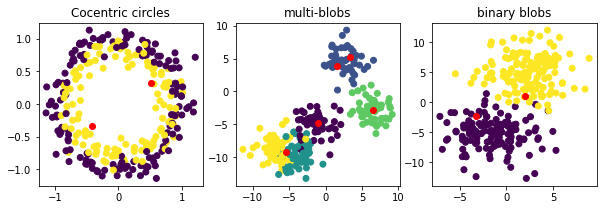

In [5]:
%matplotlib inline

np.random.seed(42)
fig, axs = plt.subplots(1, 3)
fig.set_figheight(3), fig.set_figwidth(10)
for i,(dataset, name) in enumerate([(circles, "Cocentric circles"),
                                    (multi_blobs, "multi-blobs"),
                                    (binary_blobs, "binary blobs")]):
    # Workspace 1.7
    #BEGIN 
    K = np.unique(dataset.labels).size

    axs[i].set_title(name)
    axs[i].scatter(dataset.X_train[:, 0], dataset.X_train[:,1], c=dataset.y_train)
#     k1 = KMeans(K)
#     fitted = k1.fit(dataset.X_train)
#     centroids = np.array(fitted.cluster_centers_)
    
    k_means = KMeans(K)
    hist = k_means.fit(dataset.X_train)
    centroids = k_means.centroids
    axs[i].scatter(centroids[:, 0], centroids[:, 1], c='red')
    
    #END
plt.show()


**1.8 [5 points]** For each of the three datasets (`circles`, `multi_blobs`, and `binary_blobs`), do the following on the `training` partition of the data:
- Fit a KMeans model with $k$ = # of unique lables. 
- Produce a scatter plot of the data points and color the points according to their *predicted labels*.


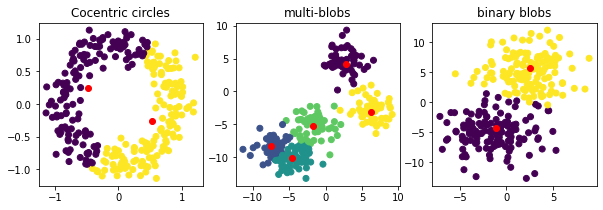

In [6]:
np.random.seed(42)
fig, axs = plt.subplots(1, 3)
fig.set_figheight(3), fig.set_figwidth(10)
for i,(dataset, name) in enumerate([(circles, "Cocentric circles"),
                                    (multi_blobs, "multi-blobs"),
                                    (binary_blobs, "binary blobs")]):
    # Workspace 1.8
    #BEGIN 
    K = np.unique(dataset.labels).size

    
    
    k_means = KMeans(K)
    hist = k_means.fit(dataset.X_train)
    y_hat= k_means.predict(dataset.X_train)    
    
    axs[i].set_title(name)
    axs[i].scatter(dataset.X_train[:, 0], dataset.X_train[:,1], c=y_hat)
    centroids = k_means.centroids
    axs[i].scatter(centroids[:, 0], centroids[:, 1], c='red')
    #END
    
plt.show()

- **1.9 [5 points]** For each dataset comment on the quality of centroids obtained and mention the observed K-means limitations. 

%BEGIN

The centroids look much more central to their cluster when dealing with the predicted labels plots, possibly overfitting?   Kmeans makes sense when your data is in somewhat distinct clusters, A failure of Kmeans is shown by the cocentric circles data, you can see it isn't very accurate with its classification.  2 classes that are interlaced in between each other and not in distinct clusters aren't classified very accurately.  Converseley multi-blobs and binary blobs are pretty accurate with how it groups the data.

%END

## K-means++ (Bonus)
We have used a random centroid initialization in K-means. In K-means++, we initialize the centroids
in a (slightly) smarter way, and it works as the following:
- Choose the first centroid uniformly at random from the data points
- For the subsequent centroids:
    - compute the distances $(d_i)$ between the data points and the current centroids (distance between a point and its nearest centroid)
    - Pick a new centroid randomly with probability proportional to $d_i ^2$ (not $d_i$!).


The rest of _K-means++_'s algorithm is exactly the same as _K-means_

- **1.10 (Bonus question) [4 points]**  Complete the `initialize_centroids` of K-means++ class and report K-means++ performance by plotting figures in a similar way to 1.7 and 1.8. Which model is better?

 You do not have to implement other methods. `KMeansPP(Kmeans)` implies that `KMeansPP` will inherit all the methods of `Kmeans` unless we choose to _override_ them (redefinition).

_Hint_: The weighted sampling can be done using `numpy`'s `choice` and its argument `p`. You do not have to worry about excluding the already picked centroids from the data. Once they're picked, their sampling weight should be equal to $0$. Make sure the probabilities sum to $1$.

In [7]:
class KMeansPP(KMeans):

    def initialize_centroids(self, X):
        # Workspace 1.10.a
        # Complete K-means++ centroid initialization. The first step (first centroid) is provided in the next line
        # Hint: You can modify self.centroids and use self.compute_distances to avoid re-coding distances computations
        centroids = X[np.random.choice(range(X.shape[0]), size=1)]
        #BEGIN 
        # code here
        #END
        return centroids

In [8]:
%matplotlib notebook
k_means_pp = KMeansPP(5)
objective_history = k_means_pp.fit(multi_blobs.X)
tests.show_progress(k_means_pp.snapshots)

IndexError: index 2 is out of bounds for axis 0 with size 1

In [ ]:
%matplotlib inline
np.random.seed(42)
fig, axs = plt.subplots(2, 3)
fig.set_figheight(6), fig.set_figwidth(10)
for i,(dataset, name) in enumerate([(circles, "Cocentric circles"),
                                    (multi_blobs, "multi-blobs"),
                                    (binary_blobs, "binary blobs")]):

    #Workspace 1.10.b
    #BEGIN 
    # code here
    #END
plt.show()

### Workspace 1.10.c
% Which model is better?

%BEGIN

%END

# Problem 2: SVM and the Kernel Trick (20 points)

We have seen during the class the dual form of the Support Vector Machine problem using a kernel $K$:

\begin{aligned}
 \max_{\alpha} \sum_i^m \alpha_i &- \frac{1}{2} \sum_{i,j}^m y^{(i)}y^{(j)} \alpha_i \alpha_j K(x^{(i)},x^{(j)})
    \\
      s.t. \text{   } \alpha_i &\geq 0 \\
      \sum_i^m \alpha_i y^{(i)} &= 0
\end{aligned}

The simplest kernel $K$ is the linear kernel 
\begin{align}
K_{lin}(x^{(i)},x^{(j)}) = <x^{(i)}, x^{(j)}>
\end{align}
 with $<.,.>$ being the scalar product.

 We'll be also using the radial kernel $K_{rad}$:
\begin{align}
 K_{rad, \gamma}(x^{(i)},x^{(j)})  = \exp \big[-\gamma ||x^{(i)} - x^{(j)}||^2]
\end{align}
And the polynomial kernel $K_{poly, c, p}$ with parameters $c$ (offset) and $p$ (degree).
\begin{align}
 K_{poly, c, p}(x^{(i)},x^{(j)})  = (<x^{(i)}, x^{(j)}> + c)^p
\end{align}

Following these kernel formulas:
- **2.1 [2 pts]** Complete `LinearKernel`. 
- **2.2 [5 pts]** Complete `RadialKernel`. 
- **2.3 [5 pts]** Complete `PolynomialKernel`. 

In [9]:
def LinearKernel(x1,x2):
    """
    Compute the kernel matrix
    @param x1: array of shape (m1,p)
    @param x2: array of shape(m2,p)        
    @return: K of shape (m1,m2) where K[i,j] = <x1[i], x2[j]>
    """
    # Workspace 2.1
    K = np.zeros((x1.shape[0], x2.shape[0]))
    #BEGIN 
    for i in range(x1.shape[0]):
        for j in range(x2.shape[0]):
#             print(x1[i] * x2[j])
            K[i, j] = sum(x1[i] * x2[j])
    #END
    return K


def RadialKernel(gamma):
    
    def RadialK(x1, x2):
        """
        Compute the kernel matrix. Hint: computing the squared distances is similar to compute_distances in K-means
        @param x1: array of shape (m1,p)
        @param x2: array of shape(m2,p)
        @return: K of shape (m1,m2) where K[i,j] = K_rad(x1[i],x2[j]) = exp(-gamma * ||x1[i] - x2[j]||^2)
         """
        # Workspace 2.2
        K = np.zeros((x1.shape[0], x2.shape[0]))
        #BEGIN 
        for i in range(x1.shape[0]):
            for j in range(x2.shape[0]):
                K[i][j] = sum(np.exp(-gamma * (x1[i]-x2[j])**2 ))
        #END
        return K
    return RadialK


def PolynomialKernel(c, p):
    
    def PolynomialK(x1, x2):
        """
        Compute the kernel matrix.
        @param x1: array of shape (m1,p)
        @param x2: array of shape(m2,p)
        @return: K of shape (m1,m2) where K[i,j] = (x1[i].x2[j] + c)^p
        """
        # Workspace 2.3
        K = np.zeros((x1.shape[0], x2.shape[0]))
        #BEGIN 
        for i in range(x1.shape[0]):
            for j in range(x2.shape[0]):
                K[i, j] = (sum(x1[i] * x2[j]) + c)**p
        #END
        return K
    return PolynomialK

Now let's train an SVM using the custom kernel functions that we just implemented. We will be using scikit-learn implementation of SVM [`more details`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC).


We provide below an example of the expected plots using the linear kernel. 

- **2.4 [2 points]** Edit the cell below to report the accuracy on the test sets for each of the two datasets visualized in the plots. How do you explain the obtained accuracies?

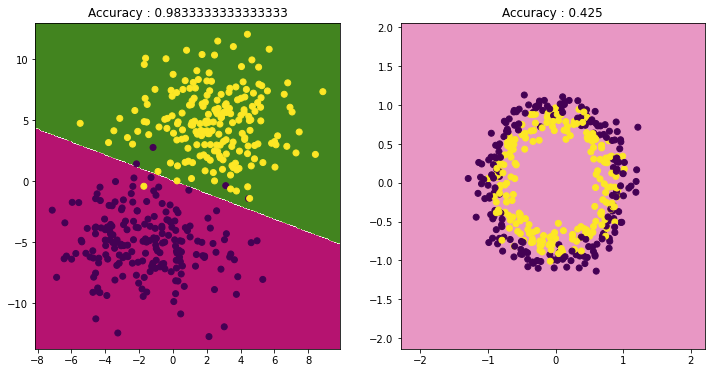

In [10]:
from sklearn.svm import SVC
%matplotlib inline
fig, axs = plt.subplots(1, 2)
fig.set_figheight(6), fig.set_figwidth(12)
svm_linear = SVC(kernel=LinearKernel)
# Workspace 2.4.a
for i, dataset in enumerate([binary_blobs, circles]):
    svm_linear.fit(dataset.X_train, dataset.y_train)
    tests.show_decision_surface(svm_linear, dataset.X, dataset.labels, axs[i])
    # Compute and print the accuracy, you can use axs[i].set_title to show it on the plot
    #BEGIN 
    curr_acc = svm_linear.score(dataset.X_test, dataset.y_test)
    axs[i].set_title("Accuracy : " + str(curr_acc))
    #END
plt.show()


### Workspace 2.4.b
% Explain the observed performance

%BEGIN
Dataset
<br>Binary_blobs with a linear Kernel had accuracy of 98.3%. This is a good kernel for the binary_blobs dataset.
<br><br>
For the circle dataset the kernel can't make a real decision and has an accuracy of 42%.  This kernel doesn't really work with the circles dataset.<br> 
%END

- **2.5 [3 points]** Plot and report SVM performance on the same datasets (`binary_blobs` and `circles`) using the *custom* radial kernel with $\gamma=2.0$. Describe the model performance and compare it to the linear kernel.

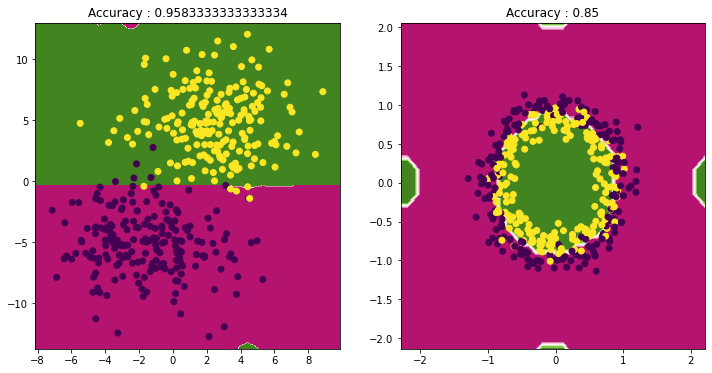

In [11]:
%matplotlib inline
fig, axs = plt.subplots(1, 2)
fig.set_figheight(6), fig.set_figwidth(12)
#Workspace 2.5.a
#BEGIN 
svm_rad = SVC(kernel=RadialKernel(2.0))
for i, dataset in enumerate([binary_blobs, circles]):
    svm_rad.fit(dataset.X_train, dataset.y_train)
    tests.show_decision_surface(svm_rad, dataset.X, dataset.labels, axs[i])
    # Compute and print the accuracy, you can use axs[i].set_title to show it on the plot
    curr_acc = svm_rad.score(dataset.X_test, dataset.y_test)
    axs[i].set_title("Accuracy : " + str(curr_acc))
plt.show()
#END

### Workspace 2.5.b
% Explain the observed performance

%BEGIN
<br>
The radial Kernel does OK with the binary blobs dataset, with accuracy of 95.8% it is pretty good but worse than the linear Kernel.
<br><br>
RadialKernel is very good with the circles dataset, it makes an actual prediction and has an accuracy of 85%.  Much better than the linearKernel on this dataset.
<br>
%END

- **2.6 [3 points]** Plot and report SVM performance on the same datasets using the *custom* polynomial kernel that you implemented with $(c,p) = (1,7)$. Describe the model performance and compare it to the two previous kernels.

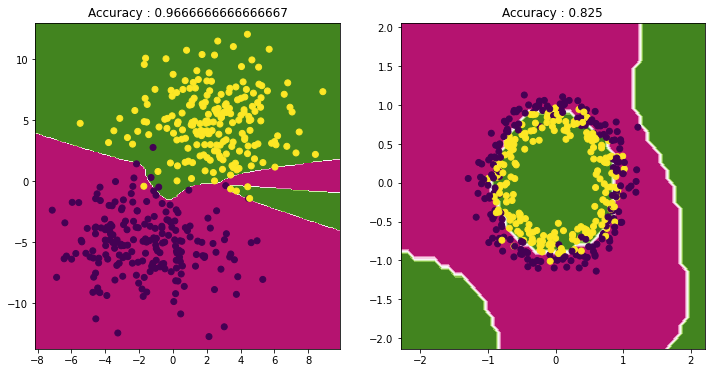

In [12]:
%matplotlib inline
fig, axs = plt.subplots(1, 2)
fig.set_figheight(6), fig.set_figwidth(12)
#Workspace 2.6.a
#BEGIN 
svm_poly = SVC(kernel=PolynomialKernel(1,7))
for i, dataset in enumerate([binary_blobs, circles]):
    svm_poly.fit(dataset.X_train, dataset.y_train)
    tests.show_decision_surface(svm_poly, dataset.X, dataset.labels, axs[i])
    # Compute and print the accuracy, you can use axs[i].set_title to show it on the plot
    curr_acc = svm_poly.score(dataset.X_test, dataset.y_test)
    axs[i].set_title("Accuracy : " + str(curr_acc))
plt.show()
#END

### Workspace 2.6.b
% Explain the observed performance

%BEGIN
<br>
For these datasets the polynomial kernel is in the middle.  For binary blobs the polynomial kernel beats the Radial Kernel but is less accurate that the LinearKernel.  Accuracy on the binary blobs dataset was 96.7%
<br><br>
For the circles dataset again the polynomialKernel was in the middle.  With accuracy of 82.5% it was much better than the linear kernel.  Using the PolynomialKernel on the circles dataset was closer to the RadialKernel but was not as accurate.
<br>

%END

# Problem 3: Neural Networks (40 points)


In this final problem, we'll be implementing our own Neural Networks framework and use it to build a Multi-Layer Perceptron (MLP). The MLP is a sequence of linear projections and activation functions, each of which will be implemented as a layer.

Each layer will have its own parameters (none for the activations), a `forward` method that applies the transformation,
and a `backward` method that computes the different gradients.


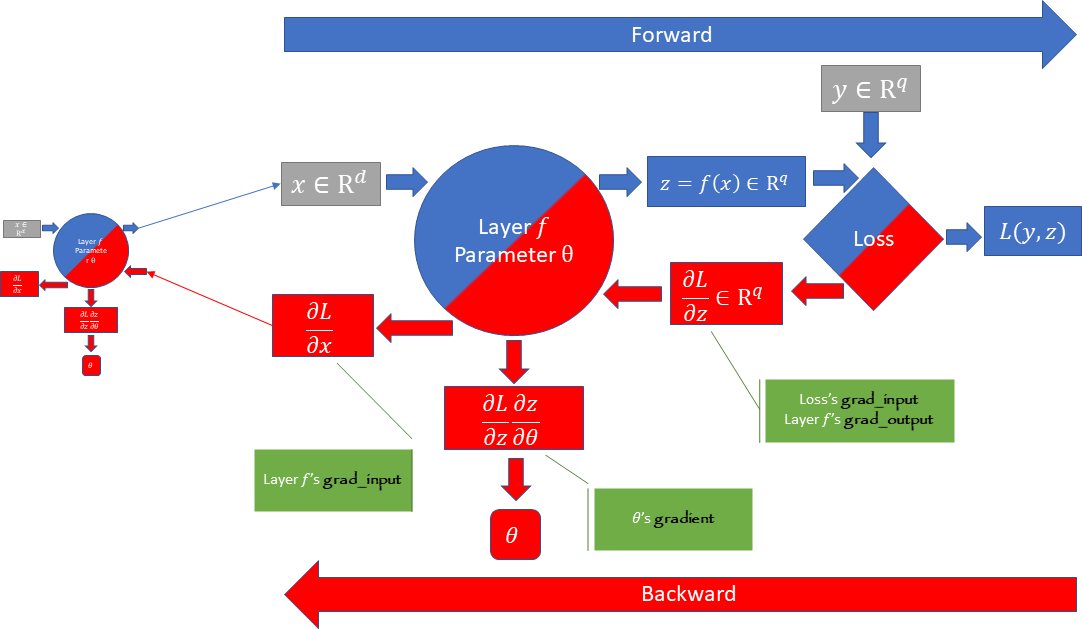
To understand how the mechanism works, let's consider the neural network that consists of one layer $f_\theta:  \mathbb{R}^d \mapsto \mathbb{R}^q$ where the parameter is optimized to minimize the loss $L$.

Our dataset consists of samples $(x_i)$ with $d$ features and a q-dimensional targets $(y_i)$. $f_\theta$ transforms  $(x_i)$ into $(z_i)$. We'll be using the Mean Squared Error (MSE) for the loss function $L$.

The neural network will have two passes:
 - forward pass where we transform the input into output,
 - and backward pass where we backpropagates the gradient and compute the gradient of the loss w.r.t to parameters.
 
Note that the gradient computation might require saving the input data from the forward pass since we won't be providing any data during the backward pass. We'll deal with that later.

Now, let's start from the layer $f_\theta: \mathbb{R}^d \mapsto \mathbb{R}^q$, with parameter $\theta$.

In order to compute the gradient for $\theta$, we first need the derivative of the loss w.r.t the layer's output $\frac{\partial L}{\partial z}$

We'll only deal with MSE loss defined as:
\begin{align}
MSE(y, z) = \frac{1}{m} \sum_{i=1}^{m} ||f_\psi(x_i) - y_i ||^2
\end{align}
, where $m$ is the sample size and $z_i = f_\theta(x_i)$.

The gradient of the loss w.r.t to its input $z$:

\begin{align}
 \frac{\partial MSE(y, z)}{\partial z}  = \frac{2}{m} (z - y)
\end{align}

- **3.1 [2 points]** Complete `MSE`'s `forward` method that returns the MSE between `y_pred` and `y_true`
- **3.2 [3 points]** Complete `MSE`'s `backward` method that returns the derivative w.r.t to the input `z`. Notice that no argument is provided for the loss backward pass and that we cached `y_pred` and `y_true` into our object-level `saved_arrays` variable during the `forward` call. 

In [13]:
class MSE:
    saved_arrays = []
    def forward(self, y_pred, y_true):
        """
        Compute the MSE loss
        @param y_pred: shape (m,q)
        @param y_true: shape (m,q)
        @return: scalar
        """
        mse = 0
        self.saved_arrays = [y_pred, y_true]
        # Workspace 3.1
        #BEGIN 
        for i in range(len(y_pred)):
           mse += (y_pred[i] - y_true[i])**2
        mse = sum(mse) / y_pred.shape[0]
#         mse = sum(mse)
        #END
        return mse

    def backward(self):
        """
        Compute the gradient w.r.t to the prediction y_pred
        @return: shape (m,q)
        """
        grad_input = None
        y_pred, y_true = self.saved_arrays # get `y_pred` and `y_true` that were saved during forward pass
        self.saved_arrays = None
        # Workspace 3.2
        #BEGIN 
        grad_input, m = np.zeros(y_pred.shape) , y_pred.shape[0]
        for i in range(len(grad_input)):
            grad_input[i] = 2/m * (y_pred[i] - y_true[i])
        #END
        return grad_input

In [14]:
# Testing MSE
mock_X = np.array([[-0.4838731,  0.08083195], [ 0.93456167, -0.50316134]])
expected_mse = 0.17090547876852463
expected_grad = np.array([[-0.24193655,  0.04041597], [ 0.46728084, -0.25158067]])
mse = MSE()
assert np.isclose(mse.forward(mock_X, mock_X/2), expected_mse)
assert np.alltrue(np.isclose(mse.backward(), expected_grad))

Now that we have the `grad_input` of `MSE`,  it's going to be `grad_output` from the perspective of the layer $f_\theta$.
- `grad_output` of layer $f_\theta$ is the derivative of the loss w.r.t to the layer's output (which is the next layer's input)
- `grad_input` of layer $f_\theta$ is the derivative of the loss w.r.t the layer's input

The `forward` method of a layer applies the transformation and keeps track of any relevant quantity for the gradient backpropagation.

The `backward` method is expected to return the gradient of the loss w.r.t to the layer's input using the chain rule.

In our implementation, we want to compute in each layer $f_\theta$:
- $\frac{\partial L }{\partial \theta} = \frac{\partial L }{\partial z} \frac{\partial z }{\partial \theta}$ is the `parameter.gradient` (if any)
- $\frac{\partial L }{\partial x} = \frac{\partial L}{\partial z} \frac{\partial f_\theta(x)}{\partial x}$, the the `grad_input` of layer $f$ and return it

The backward pass consists of sequentially doing what we've just mentioned for $f_\theta$

1. get the initial `grad_output` from loss layer (top layer)
2. In reverse order:
    - pass current `grad_output` to the next layer's backward
    - inside the layer's backward: compute `grad_input` and `parameter.gradient` (if there are any parameters)
    - `grad_output` <- `grad_input`
    - repeat 2
3. Loop through the parameters and apply the gradient

We'll apply this to our first layers: `sigmoid` and `ReLU`.
We don't have to worry about `parameter.gradient` since they don't have any parameters.


- **3.3 [3 points]** Complete the `forward` method of the `Sigmoid(Layer)`. The method applies the sigmoid activation to x. Don't forget to clip x to the interval [-25.0, 25.] before applying the activation. Save activation values to use them in the `backward` call, for that you should use `self.saved_arrays` to cache them. 

- **3.4 [5 points]** Complete the `backward` method of the `Sigmoid(Layer)`. The method should use the chain rule to compute `grad_input` of the layer. Note that this method receives $\frac{\partial L}{\partial z}$ `grad_output` as an argument so you just need to find  $\frac{\partial \sigma(x)}{\partial x}$.

- **3.5 [3 points]** Complete the `forward` method of the `ReLU(Layer)`. The method applies the ReLU activation to x. Don't forget to save $x$ values to use them in the `backward` call.

- **3.6 [5 points]** Complete the `backward` method of the `ReLU(Layer)`. Compute `grad_input` in a similar way to 3.4. Note that $\frac{\partial \text{ReLU}(x)}{\partial x} = 1$ for ${x > 0}$ and 0 otherwise.

In [15]:
import numpy as np

class Layer(object):
    """
    Template Layer that will be used to implement all other layers
    """
    def __init__(self, name=""):

        self.saved_arrays = [] # You might need them for the backward pass
        self.parameters = []
        self.name = name # to idnetify the layer

    def forward(self, x):
        """
        In the forward pass we receive an array containing the input and return an array containing the output.
        You can cache arbitrary objects for use in the backward pass in self.saved_arrays
        @param x: input array of size (batch_size, d)
        @return: output array
        """
        pass

    def backward(self, grad_output):
        """
        In the backward pass we receive an array containing the gradient of the loss with respect to the output,
        and we need to compute the gradient of the loss with respect to the input and the gradient of the weights (default as 0)
        @param grad_output:
        @return: grad
        """
        pass
    
class Sigmoid(Layer):

    def forward(self, x):
        """
        Apply the sigmoid function to x. Don't forget to clip x to the interval [-25.0, 25.] before applying the activation
        @param x: input array of shape (batch_size, q)
        @return: elementwise sigmoid of shape (batch_size, q)
        """
        sigmoid = np.zeros_like(x)
        # Workspace 3.3
        #BEGIN 
        clipped = np.clip(x, -25.0, 25.0)
        sigmoid = 1/(1 + np.exp(-clipped))
        self.saved_arrays = [x]
        #END
        return sigmoid

    def backward(self, grad_output):
        """
        Compute the grad_input and grad_parameters. Activatins don't have parameters, so 0 gradient is the default
        @param grad_output: input array of shape (batch_size, q)
        @return: grad_input: of shape (batch_size, q)
        """
        grad_parameters = 0
        grad_input = 0

        # Workspace 3.4
        #BEGIN 
        x = self.forward(self.saved_arrays[0])
        grad_input = grad_output * x * (1-x)
        #END
        return grad_input

class ReLU(Layer):

    def forward(self, x):
        """
        Apply the ReLU function to x.
        @param x: input array of shape (batch_size, q)
        @return: element-size ReLU of shape (batch_size, q)
        """
        relu = 0
        # Workspace 3.5
        #BEGIN 
        relu = np.maximum(0, x)
        self.saved_arrays = [x]
        #END
        return relu

    def backward(self, grad_output):
        """
        Compute the grad_input and grad_parameters. Activatins don't have parameters
        @param grad_output: input array of shape (batch_size, q)
        @return: grad_input of shape (batch_size, q)
        """
        grad_input = 0
        grad_parameters = 0
        # Workspace 3.6
        #BEGIN 
        x = self.forward(self.saved_arrays[0])
        grad_input = np.multiply(grad_output, (x > 0))
        
        #END
        return grad_input

In [16]:
# Sigmoid Tests
mock_X = np.array([[-0.4838731,  0.08083195], [ 0.93456167, -0.50316134]])
grad_output = np.array([[ 0.19960269,  0.20993069], [-0.85814751, -0.41418101]])
sig_x = np.array([[0.38133797, 0.52019699], [0.71799983, 0.37679803]])
grad_sig_x = np.array([[ 0.04709013,  0.05239704],[-0.17375434, -0.09725851]])
sigmoid = Sigmoid()
assert np.alltrue(np.isclose(sigmoid.forward(mock_X), sig_x))
assert np.alltrue(np.isclose(sigmoid.backward(grad_output), grad_sig_x))

In [17]:
# ReLU Tests
relu_x = np.array([[-0.,  0.08083195],[ 0.93456167, -0.]])
grad_relu_x = (np.array([[ 0.,  0.20993069],[-0.85814751, -0.]]))
relu = ReLU()
relu.forward(np.array([1,0,5,-3]))
assert np.alltrue(np.isclose(relu.forward(mock_X), relu_x))
assert np.alltrue(np.isclose(relu.backward(grad_output)[0], grad_relu_x[0]))

Now we'll move to the exciting part. We'll implement our own _dense_ (linear) layer that has two parameters $\theta=(w,b)$,
with $w$ being the weights array and $b$ the bias.
This layer $f_\theta$ projects a $d$ dimensional input into an $q$ dimensional space as follows:

\begin{align}
f_\theta(x) = xw + b
\end{align}

and its derivatives are:

\begin{align}
\frac{\partial f_\theta}{\partial x} &= w \\
\frac{\partial f_\theta}{\partial w} &= x^T \\
\frac{\partial f_\theta}{\partial b} &= 1_m
\end{align}

where $1_q$ is the ones vector with the same dimension as $b$


To help you keep track of the gradient, we will be wrapping the parameters numpy arrays using the `Parameter` class.
`Parameter` instances are an extension of numpy arrays, but they have additional:
 - attribute `gradient`: initialized with zeros and has the same shape as the array
 - method `zero_gradient`: resets the gradient values to zero
 - method `apply_gradient(grad)`: adds `grad` to the array
 - optional attribute `name`: This is going to be useful when implementing the bonus `Adam` optimizer

_Hint_: At this level, our implementation imitates Pytorch

In [18]:
class Parameter(np.ndarray):
    def __new__(cls, input_array, name=""):
        array = np.asarray(input_array).view(cls)
        array.gradient = np.zeros(array.shape)
        array.name = name
        return array

    def __array_finalize__(self, array):
        if array is None: return
        self.gradient = getattr(array, "gradient", None)
        self.name = getattr(array, "name", None)

    def zero_gradient(self):
        self.gradient = self.gradient * 0.0

    def apply_gradient(self, grad):
        self[:] = self[:] + grad[:]


In [19]:
# demo on how to use Parameter
w = Parameter(np.ones(3, ), name="W_0")
print("Initial w:", w, id(w))  # object memory identifier, same id = same object
print("Name of w:", w.name)
print("Initial gradient:", w.gradient)
w.gradient = np.array([0.1, 0.2, 0.3])
print("Gradient:", w.gradient)
w.apply_gradient(-0.2*w.gradient) # learning rate 0.2
w.zero_gradient()
print("Final w:", w, id(w))
print("Final gradient:", w.gradient)

Initial w: [1. 1. 1.] 1860816461600
Name of w: W_0
Initial gradient: [0. 0. 0.]
Gradient: [0.1 0.2 0.3]
Final w: [0.98 0.96 0.94] 1860816461600
Final gradient: [0. 0. 0.]


- **3.7 [3 points]** Complete the `forward` method of the `Dense` layer to apply the linear projection. Don't forget to save `x` values to use them in the `backward` call

- **3.8 [6 points]** Complete the `backward` method of the `Dense` layer to compute the gradients using the aforementioned formulas.

In [20]:
class Dense(Layer):

    def __init__(self, input_dimension, output_dimension, name=""):
        """
        Initialize the layer's parameters
        :param input_dimension: The dimension of the input data
        :param output_dimension: the dimension of the output
        :param name: optional, name to identify the layer
        """
        super().__init__(name)
         # Do not change the initialization method
        # Initialize the bias and weights using random normal distribution
        # Scale each array by 1 / sqrt(N) where N is the number of elements in the array
        self.bias = Parameter(np.random.randn(1, output_dimension) / output_dimension**0.5)
        self.weights = Parameter(np.random.randn(input_dimension, output_dimension) / (output_dimension*input_dimension)**0.5)
        self.parameters=[self.bias, self.weights]

    def forward(self, x):
        """
        Apply the linear projection and save the necessary objects for the backward pass
        @param x of shape (m,input_dimension)
        @return: z = xw + b of shape (m,output_dimension)
        """
        output = 0
        # Workspace 3.7
        #BEGIN 
        output = np.dot(x , self.weights) 
        output = output + self.bias
        self.saved_arrays = [x]
        #END
        return output

    def backward(self, grad_output):
        """
        Compute the gradients using the aforementioned formulas. Do not change the return signature
        Update the parameters gradient attribute directly
        @param grad_output: shape (m, output_dimension)
        @return: grad_input of shape (m, input_dimension)
        """
        self.weights.zero_gradient()
        self.bias.zero_gradient()
        # Workspace 3.8
        #BEGIN 
        x , = self.saved_arrays
        temp = np.transpose(x)
        grad_input = np.dot(grad_output, np.transpose(self.weights))
        self.weights.gradient = np.dot(temp, grad_output)
        self.bias.gradient = np.sum(grad_output, axis=0)
        #END
        return grad_input

In [21]:
# Dense layer test
mock_X = np.array([[-0.4838731,  0.08083195], [ 0.93456167, -0.50316134]])
np.random.seed(42)
dense = Dense(2,2)
dense.forward(mock_X)
gradient_input = dense.backward(grad_output)
dense_x = np.array([[ 0.18506688, -0.47570709], [ 0.71279085,  0.67281937]])
grad_dense_x = np.array([[ 0.22450554, -0.04794509],[-0.59331118,  0.14895661]])
grad_dense_weights = np.array([[-0.89857414, -0.48865751],[ 0.44792093,  0.22536898]])
grad_dense_bias = np.array([[-0.65854482, -0.20425032]])
assert np.alltrue(np.isclose(dense_x, dense.forward(mock_X)))
assert np.alltrue(np.isclose(grad_dense_x, gradient_input))
assert np.alltrue(np.isclose(grad_dense_weights, dense.weights.gradient))
assert np.alltrue(np.isclose(grad_dense_bias, dense.bias.gradient))

Now that we implemented the layers, we need 2 more ingredients:
- Optimizer: to manage how to update the layers parameters using the computed gradients
- Network: to store our stack of layers and manage the forward and backward passes
    
We provide below implementation for the `SGD` class and the `Network` class. You need to go through the comments to understand how the classes work to be able to answer the follwoing questions. 

In [22]:
class SGD(object):

    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        self.layers = None

    def set_layers(self, layers):
        """
        Saves the layers stack
        @param layers: list of Layer instances (the same stack stored in the network)
        @return: None
        """
        self.layers = layers

    def apply_gradients(self):
        """
        Multiply the gradients by the learning_rate before passing them to apply_gradient of the layers
        We loop through self.gradients (List of layers gradients computed from the backward pass).
        Then we call the corresponding layers apply_gradient with the scaled gradients.
        gradients[i] is a list on numpy as arrays that correspond to grad_parameters of layers[i]
        @return: None
        """
        for layer in self.layers:
            for p in layer.parameters:
                p.apply_gradient(- self.learning_rate * p.gradient)

In [23]:
class Network(object):

    def __init__(self, optimizer, loss):
        self.optimizer = optimizer
        self.loss = loss
        self.layers = []
        self.optimizer.set_layers(self.layers)

    def add_layer(self, layer):
        self.layers.append(layer)

    def predict(self, x):
        return self.forward(x)

    def forward(self, x):
        """
        Given input x, apply the self.layers in the natural order and return the output
        @param x: shape (m,d)
        @return: array of shape (m,p) where p is the output dimension of the last linear layer
        """
        output = x
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def backward(self):
        """
        Perform the backward pass, starts with the loss to get the first grad_output
        Loop through the layers in backward pass by providing the grad_output and 
        storing the grad_parameters from each layer
        Warning: should only be called after a forward call
        @return: list of grad_parameters from the layers
        """
        grad_output = self.loss.backward()
        parameters_gradients = []

        for layer in self.layers[::-1]:
            grad_output = layer.backward(grad_output)

    def fit_batch(self, batch_x, batch_y):
        output = self.forward(batch_x)
        loss = self.loss.forward(output, batch_y)
        self.backward()
        self.optimizer.apply_gradients()

    def fit(self, X, y, batch_size=32, epoch=1):
        """
        Compute the output of the network and the loss based on y
        Call optimizers.set_gradients with the accumulated grad_parameters
        @param x: input sample of shape (batch_size, m)
        @param y: target array of shape (batch_size, 1)
        @return: Loss value
        """
        output = self.forward(X)
        loss = self.loss.forward(output, y)
        self.backward()
        self.optimizer.apply_gradients()
        return loss

- **3.9 [5 points]** Create a neural network with your own choice of layers and activations. The last output should have dimension 1 to match that of our target. Since our target variable is either 0 or 1, you should use Sigmoid activation as the last layer to get outpouts in interval $[0,1]$. You'll be tweaking this to find a good choice of layers for the next questions

In [24]:
# Workspace 3.9
network = Network(optimizer=SGD(learning_rate=0.5), loss=MSE())
#BEGIN 

network.add_layer(Dense(input_dimension=2, output_dimension=32))
network.add_layer(ReLU())
network.add_layer(Dense(input_dimension=32, output_dimension=16))
network.add_layer(ReLU())
network.add_layer(Dense(input_dimension=16, output_dimension=1))
network.add_layer(Sigmoid())
        
#END

- **3.10 [5 points]** Using a `batch_size` of 10, loop through the `circles` train parition for 100 `epochs` to minimize the MSE.
Compute and plot the MSE at the end of each epoch on the entire dataset (using `circles.data` and `circles.labels`). You might need to go back and tweak the neural network (layers, learning rate of SGD) to get good performance.

You'll have to try different learning rates to find the right one. You should expect an MSE <= 0.1 at the end of the training.

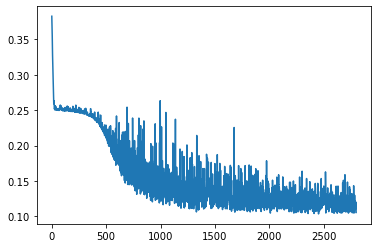

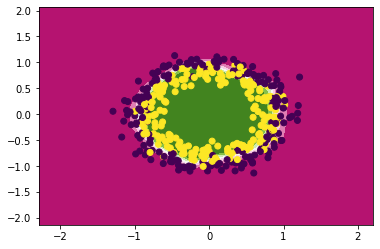

In [25]:
batch_size = 10
epochs = 100
losses = []
# Workspace 3.10
for _ in range(epochs):
    batch_idx = list(range(0, len(circles.X_train),batch_size))
    np.random.shuffle(batch_idx)
    for i in batch_idx:
        batch_x = circles.X_train[i:i+batch_size]
        batch_y = circles.y_train[i:i+batch_size].reshape(-1,1)
        _ = network.fit(batch_x, batch_y)
    #BEGIN 
        y_hat = network.predict(circles.X)
        cur_mse = network.loss.forward(circles.labels.reshape(-1,1), y_hat)
        losses.append(cur_mse)

        
    #END
plt.plot(np.arange(len(losses)), losses)
plt.show()
tests.show_decision_surface(network, circles.X, circles.labels)

### Adam : Adaptive moment estimation (Bonus)
SGD optimizer the simplest we can use. However, the batch estimation of the gradient can be noisy. [Adam](https://arxiv.org/pdf/1412.6980.pdf) optimizer smoothes out the gradient
using a moving average of past gradients (first moment) and scales them using a moving average estimate of their norm (second moment).
It works as follows:

- Parameters: learning rate $\alpha$, decay rates $\beta_1$ and $\beta_2$.
- Initialize: $t=0$, $m = 0$, $v = 0$ (each network parameter should have its corresponding $m$ and $v$)
- For each `apply_gradient` call given gradient $g$ do:
    - $t \leftarrow t+1$
    - $m \leftarrow \beta_1 m + (1-\beta_1) g$
    - $v \leftarrow \beta_2 v + (1-\beta_2) g^2$
    - $\hat{m} \leftarrow \frac{1}{1 - \beta_1 ^ t} m$
    - $\hat{v} \leftarrow \frac{1}{1 - \beta_2 ^ t} v$
    - apply gradient $\alpha .\hat{m} / (\sqrt{\hat{v}} + \epsilon)$ (division and sqrt are element wise, epsilon is a small constant to avoid zero division, we'll use $\epsilon =10^{-8}$)
Refer to the original paper is there is any confusion around the iterations

**3.11 (Bonus Question) [5 points]** Complete Adam optimizer class and redo 3.9 and 3.10 using Adam optimizer instead. Try a learning rate that gave a bad performance using SGD.
Which optimizer is better? why?

In [26]:
class Adam(SGD):
    def __init__(self, learning_rate, beta_1, beta_2):
        super(Adam, self).__init__(learning_rate)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.first_moment = None
        self.second_moment = None
        self.time_step = 0
        self.gradients = []

    def apply_gradients(self):
        # Workspace 3.11.a
        #BEGIN 
        # code here
        #END
        self.gradients = None

In [27]:
# Testing Adam optimizer
mock_X = np.array([[-0.4838731,  0.08083195], [ 0.93456167, -0.50316134]])
mock_y = 0*mock_X + 1
expected_weights = np.array([[-0.07104128,  0.36260954], [-0.50247728, -0.46956692]])
adam_network = Network(Adam(1e-1, 0.9, 0.99), MSE())
np.random.seed(42), adam_network.add_layer(Dense(2,2))
for _ in range(4):
    adam_network.fit(mock_X, mock_y)
assert np.alltrue(np.isclose(adam_network.layers[0].weights, expected_weights))

AssertionError: 

In [ ]:
batch_size = 10
epochs = 100
losses = []

# Workspace 3.11.b
#BEGIN 
# code here
#END

### Workspace 3.11.c
% Which optimizer is better

%BEGIN

%END

### Bonus Problem: Deep Q-Learning (6 points)

This problem has a low [#points / effort] ratio, but we promise it's going to be fun and rewarding.
We'll start first by explaining two elements of Markov Decision Process (MDP): policy $\pi$ and its state-action functions $Q_\pi$.


In [ ]:
import numpy as np
import data
import tests
import tqdm.notebook
import matplotlib.pyplot as plt

In [ ]:
environment = data.GRID(grid_size=16, max_time=2000)
environment.reset()
environment.render()


We'll be using a _4-rooms_ environment where the goal of the agent (white square) is to reach the target (red square).
The grid is 16 by 16, so there are 256 states. Not all the states are accessible, since the agent can't cross the blue walls.
Each state $s$ is represented as a tuple $(x_s, y_s)$ that reflects the position of the agent.

There are 4 possible actions at each state (clockwise): Up (0), Right(1), Down(2), Left(3).
The agent gets a penalty (reward = -1) if it hits the blue walls and a reward = 1 if it reaches the target.
The episode ends (game over) when the target is reached or the agent has taken 2000 steps.

We will be using Q-learning to find a good policy that will allow us to reach the target before the time runs out.

At step $t$, the agent is located at state $s_t$ and chooses an action $a_t = \pi(s_t)$ following the policy $\pi$

The agent then gets reward $r_t$ and moves to state $s_{t+1}$. The process repeats until we reach a final state $s_T$ (`game_over == True`)

We'll call a replay a sequence of tuples $(s_t, a_t, r_t, s_{t+1})$.

In [ ]:
# How to create a replay with one element
# repeat as long as game_over is false
replay = []
current_state = environment.reset()
action = 2
print("Initial state:{}".format(current_state))
new_state, reward, game_over = environment.step(action)  # down
replay.append((current_state, action, reward, new_state))
current_state = new_state
print("Took action: {}".format(data.grid.ACTIONS_NAMES[action]))
print("New state: {}\nReward: {}\nGame over:{}".format(new_state, reward, game_over))
environment.render()

Starting at time $t=0$, The agent's goal is to maximize the expected discounted rewards:
\begin{align}
\eta_\pi = \sum_{t | a_t =\pi(s_t)} \gamma^t r_t
\end{align}
$0<\gamma<1$ is the discount rate. We'll be using $\gamma = 0.95$

The main role of discounting the rewards is to motivate the agent to achieve the goal as early as possible (no procrastination).

It makes reaching the goal at $t=1$, for example, more desirable than at $t=100$: $r_1=1$ contributes $\gamma^1 =0.95$ while $r_{100} = 1$ will only count as $\gamma^{100} =0.006$ in $\eta_\pi$.

$Q_\pi(s_t, a_t)$ is defined as the expected discounted rewards if we start at state $s_t$, take an initial actions $a_t$, and
follow the policy $\pi$ to decide the remaining action $(a_{t+1},..... a_{T-1})$.

\begin{align}
Q_\pi(s,a) = \eta_\pi, \text{ such that } s_0 = s \text{ and } a_0 = a
\end{align}

The principle behind Q-learning, as the name suggests, is to learn the optimal $Q^*$.
Since at each instant $t$, we want to pick the action that yields the best expected rewards, the optimal policy $\pi^*$ would be:
\begin{align}
\pi^*(s) = \arg\max_a Q^*(s, a)
\end{align}

__So how do we learn the optimal $Q^*$?__

By exploring the environment and saving a replay $\text{Replay} = \{(s_t, a_t, r_t, s_{t+1})| t\leq T\}$ (one that reaches the goal, hopefully),

we can use _Bellman equations_ to update our estimate of the $Q$ function in the following way:
\begin{align}
Q_{new}(s_t, a_t) \leftarrow r_t + \gamma \max_a Q_{old}(s_{t+1}, a), \;\;\; \forall \; (s_t, a_t, r_t, s_{t+1})\in \text{Replay}
\end{align}

We can prove that repeating this update will make our estimate converge to a unique optimal state-action value function $Q^*$.

Instead of "brutally" updating Q, we'll use a learning rate $\alpha$, so that the update would be :
\begin{align}
Q_{new}(s_t, a_t) \leftarrow  (1-\alpha)Q_{old}(s_t, a_t) + \alpha\big[r_t + \gamma \max_a Q_{old}(s_{t+1}, a) \big]
\end{align}

In this first part, we'll use an array `Q` of shape (16 x 16 x 4) to store $Q$, and the value $Q(s,a)$ would be accessed via `Q[x_s, y_s, a]`.

- 4.1 **[3 points]** Complete the class method `TabularQ.update` to apply _Bellman_ updates provided a replay

In [ ]:
class TabularQ:
    def __init__(self, gamma=0.95, learning_rate=0.01):
        self.Q = np.zeros((16, 16, 4))
        self.gamma = gamma
        self.alpha = learning_rate

    def update(self, replay):
        for s_t, a_t, r_t, s_t_p_1 in replay:
            # Workspace 4.1
            #BEGIN 
            # code here
            #END

    def best_action(self, s):
        action = np.argmax(self.Q[s[0], s[1]])
        return action

    def save(self, checkpoint_name):
        np.savez_compressed(checkpoint_name, Q=self.Q)

    def load(self, checkpoint_name):
        self.Q = np.load(checkpoint_name +".npz" )["Q"]

class Policy():

    def __init__(self, Q, epsilon=1):
        self.Q = Q
        self.epsilon = epsilon

    def act(self, state):
        if np.random.uniform(0, 1) <= self.epsilon:
            return np.random.choice([0, 1, 2, 3])
        else:
            return self.Q.best_action(state)

Now we have to address a different question: when we explore the environment, how should we choose the actions?

One approach is to follow a $\epsilon$-greedy policy, where we choose a random action with probability $\epsilon$ and the best action according to Q with probability $1-\epsilon$.

For instance, if $\epsilon=1$, all actions are chosen randomly. For $\epsilon=0$, all actions are chosen _greedily_.
A common practice is to start with $\epsilon=1$ and decay it to 0 as we generate replays. How fast we decay it is related to the famous _exploration-exploitation_ dilemma in Reinforcement Learning.

4.2 **[2 points]** Complete the cell below to generate replays and update `tabular_Q` for `n_episodes`. You're free to choose your own decaying rate for $epsilon$ (including a 0 decay)


In [ ]:
tabular_Q = TabularQ()
n_episodes = 20
greedy_policy = Policy(tabular_Q, epsilon=1.0)
decay = 0.995
def play(environment, policy):
    # Returns one episode's replay and the total accumulated rewards
    replay = []
    current_state = environment.reset()
    game_over = False
    total_rewards = 0
    while not game_over:
        action = policy.act(current_state)
        new_state, reward, game_over = environment.step(action)
        replay.append((current_state, action, reward, new_state))
        current_state = new_state
        total_rewards += reward
    return replay, total_rewards

for _ in range(n_episodes):
    # Workspace 4.2
    #BEGIN 
    # code here
    #END

Now let's examine how the agent behaves a following random policy vs our Q-learning policy.

You should notice that if you run Q-learning multiple times, you might get different policies (different ways to reach the target) : we've mentioned before that $Q^*$ is unique, it's not the case for $\pi^*$

In [ ]:
_ = play(environment, Policy(tabular_Q, epsilon=1.0)) # completely random policy
tests.save_frames(environment.episode, target_mp4="uniform") # saves the episode to uniform.mp4
tests.display_video("uniform") # display uniform.mp4

In [ ]:
_ = play(environment, Policy(tabular_Q, epsilon=0.0)) # optimal policy
tests.save_frames(environment.episode, target_mp4="best_tabular")
tests.display_video("best_tabular") # display uniform.mp4

- 4.3 **[1 point]** To get the full credit of the previous questions, you'll have to submit a zip file `q_learning.zip` that includes `uniform.mp4`, `best_tabular.mp4` from previous cells and `best_tabular.npz` from the cell below

_Hint_:  If cells ran correctly, the files should appear in the same path as the notebook

In [ ]:
tabular_Q.save("best_tabular")